In [1]:
# set working directory
import sys
import os
from pathlib import Path
sys.path.insert(0, Path(os.getcwd()).parent)
os.chdir(sys.path[0])

# Supervised ML from Seismic Attributes

In [4]:
# Import libraries
import pandas as pd
import geopandas as gpd
import pickle

In [ ]:
# Import functions from the functions script
from functions.functions import pre_process
from functions.functions import run_umap
from functions.functions import get_classes
from functions.functions import preprocess_pipeline
from functions.functions import Umap_vis
from functions.functions import clusters
from functions.functions import re_order_clusters
from functions.functions import Umap_vis_alternative

## Prepare the Triaining and Test sets

In [9]:
# Import the gas field and dry structure polygons
gas = gpd.read_file('data/boundaries/Gas_json.geojson')
nogas = gpd.read_file('data/boundaries/No_Gas_json_3857.geojson')

In [69]:
# Import the UMAP coordinates for each feature
with open('outputs/umap_coords.pkl', 'rb') as file:
    data = pickle.load(file)

In [70]:
# Function to remove redundant columns
def remove_columns(data):
    
    for df in data:
        data[df] = data[df].drop(['class', 'clusters', 'Cp_Product', 'reordered_cluster'], axis=1)
    
    return data

In [71]:
# Remove redundant columns
data = remove_columns(data)

In [ ]:
# Get the class labels

train_val = {}

for df in data:
       
    d = get_classes(data[df], gas, nogas, 0, 0)
    d1 = get_classes(data[df], gas, nogas, 1, 1)
    
    concat = data[df].copy()
    
    concat['train'] = d['class']
    concat['test'] = d1['class']
    
    train_val[df] = concat
    

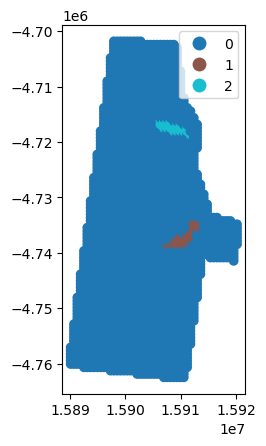

In [46]:
import matplotlib.pyplot as plt

# Plot the classes in plan view to check that they are correct
gdf = gpd.GeoDataFrame(
    train_val['feats_clr'], 
    geometry='geometry')

# Plot using GeoPandas
fig, ax = plt.subplots()
gdf.plot(ax=ax, column='class', legend=True, categorical=True, marker='o', linestyle='')

# Show the plot
plt.show()

In [103]:
# define the training set
training_set = train_val['feats_greyscale'].loc[train_val['feats_greyscale']['train'] != 0]

#define a test set
test_set = train_val['feats_greyscale'].loc[train_val['feats_greyscale']['test'] != 0]

# Supervised Classification

In [91]:
# Import libraries
from xgboost import XGBClassifier
import shap
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from imblearn.under_sampling import RandomUnderSampler 
import numpy as np

In [92]:
# define the random undersmapler
rus = RandomUnderSampler(random_state=42)

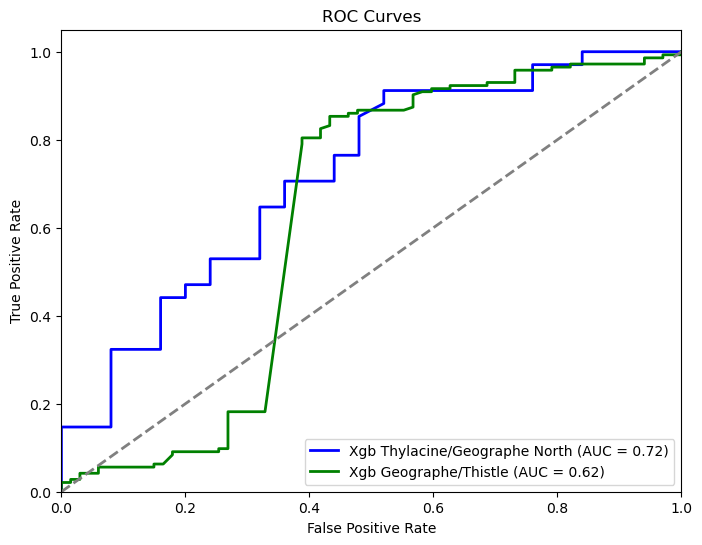

In [106]:
# run the Thylcaine/Geographe North Scenario
xgb, xgb1, roc, roc1, plt = train_val(training_set, test_set, rus)

In [132]:
X =data['feats_greyscale'].drop(['geometry'], axis=1)

# run inference over the full dataset
preds = xgb1.predict_proba(X) 
 
X['preds'] = preds[:, 1:2]

In [133]:
plot = data['feats_greyscale'].copy()
plot['preds'] = preds[:, 1:2] 

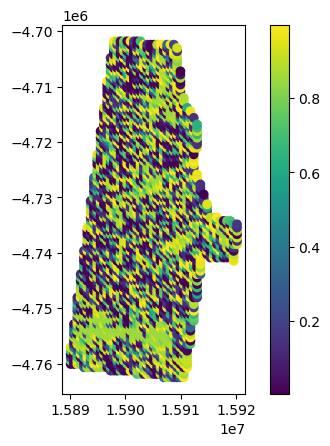

In [134]:
# plot the predictions
# Plot the classes in plan view to check that they are correct
gdf = gpd.GeoDataFrame(
    plot, 
    geometry='geometry')

# Plot using GeoPandas
fig, ax = plt.subplots()
gdf.plot(ax=ax, column='preds', legend=True, categorical=False, marker='o', linestyle='')

# Show the plot
plt.show()